In [1]:
##### nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build

# !pip install snowflake --user
# !pip install snowflake-connector-python --userqr4
# !pip install category_encoders
# !pip install xgboost
# !pip install fuzzywuzzy --user
# !pip install lightgbm --user


import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

pd.options.mode.chained_assignment = None

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


## Functions

In [3]:
def get_agg_first_views(df_in, grpby_title, agg_col, first_view_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()

    return df_in

def get_plot(dflist, varlist, labellist=None,  ## Old
              title=None, config={}, x_var='order_date', y_var='y_var',  mode='lines+markers'):
    ## Create dataframe x var combinations (plot all variables for each dataframe)
    dfvarlist=itertools.product(*[dflist,varlist])
        
    ## For every dataframe x variable, create a data trace for plotting
    data=[]    
    for dfvar, name in zip(dfvarlist, labellist):
        dfplt,var=dfvar[0], dfvar[1]
        data = data + [go.Scatter(x=dfplt[x_var], y=dfplt[var], mode=mode, name=name)]  

    ## Initiate offline plot and create plot
    py.offline.init_notebook_mode(connected=True) 
    layout = dict(title = title,
                  xaxis = dict(title = x_var), #, range=['2017-09-01','2017-02-01']
                  yaxis = dict(title = y_var),
                  autosize=False,
                  width=(600),
                  height=(400),
                  showlegend=True,
                 )
    fig = dict(data=data, layout=layout)
    return fig

def evaluate_pred_group(df_plt, grpby, key, pred_list):

    for quarter, group in df_plt.groupby(grpby):
        actuals_mean=group['first_views'].mean()
        actuals_sum=group['first_views'].sum()
        print('_____________________________________________________________')
        print(f'{key} {quarter} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
        for i in ['median_mx'] + list_postfix:  
            mae = MAE(group['first_views'], group[f'first_views_decay_{i}'])
            pred= group[f'first_views_decay_{i}'].sum()
            print(f'{key} {quarter} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')
    
    return

def evaluate_pred_plt(df_plt, grpby, var_list):
    mean_var_list = [f'mae_{i}' for i in var_list]
    sum_var_list = ['first_views'] + var_list 
    mean_dic = dict(zip(mean_var_list, ['mean'] * len(mean_var_list)))
    sum_dic = dict(zip(sum_var_list, ['sum'] * len(sum_var_list)))
    
    # Get absolute error at agg_time- title level
    df_grp = df_plt.groupby(by=grpby).agg(sum_dic).reset_index()
    for i in var_list:
        df_grp[f'mae_{i}'] = (df_grp[i] - df_grp['first_views']).abs()  ## mae is actually ae here. mean taken in the next step

    ## aggregate to agg_time level (month, quarter)
    agg_dic =  {k: v for d in (mean_dic, sum_dic) for k, v in d.items()}
    df_grp = df_grp.groupby(by=grpby[:-2]).agg(agg_dic).reset_index()
    for i in var_list:
        df_grp[f'pct_error_{i}'] = (df_grp[i] - df_grp['first_views'])/df_grp['first_views']*100

    return df_grp

def get_pred_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'first_views_decay_{i}' for i in ['median_mx', 'dev_b']] + ['first_views'] ## Variables to be plotted
            ,'title': title  ## Plot title
            ,'labellist':['Median','XGB', 'Actual'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': 'First views'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    py.offline.iplot(fig)
    
    return 

def get_pct_error_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'pct_error_first_views_decay_{i}' for i in ['median_mx', 'dev_b']] ## Variables to be plotted
            ,'title':title  ## Plot title
            ,'labellist':['Median','XGB'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': '% error (Quarter aggregate)'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    fig['layout']['yaxis'].update({'ticksuffix':'%'})
    py.offline.iplot(fig)
    
    return 

def munge_features(df_in):
    df_in['start_year'] = pd.to_datetime(df_in['effective_start_date']).dt.year
    df_in['start_month'] = pd.to_datetime(df_in['effective_start_date']).dt.month
    df_in['start_year_month'] = df_in['effective_start_date'].dt.strftime('%Y-%m')
    df_in['start_quarter'] = df_in['effective_start_date'].dt.quarter

    df_in['ref_tot'] = df_in[['ref_follows','ref_remake_of','ref_spin_off_from','ref_version_of']].sum(axis=1)
    df_in['ref_ref_tot'] = df_in[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)
    
    df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==1), ['tier']] = 0
    df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==2), ['tier']] = 1
    
    df['first_views_log'] = np.log(df['first_views'])
    return df_in



def get_resampled_data(df_in, df_in_new):
    target_count = df_in[df_in.tier==3].shape[0]
    print(date_pred, target_count, df_in[df_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_in[df_in.category=='Popcorn'].sample(int(round(target_count*0.2)), replace=True)
        df_train_in_tier0_new = df_in_new[df_in_new.category=='Popcorn'].sample(int(round(target_count*0.5)), replace=True)
        df_train_in_tier1 = df_in[(df_in.tier==1) & (df_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_in[(df_in.tier==2) & (df_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_in[df_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier0_new, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_in_new[(df_in_new.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_in_new[(df_in_new.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_in_new[df_in_new.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)
    return df_train_in

def get_decay_data_title(df_plt, grpby):
    df_plt = df_plt[grpby + ['days_since_premiere','first_views']].sort_values(by=grpby+['days_since_premiere'])
    df_plt['first_views_sum'] = df_plt.groupby(grpby)['first_views'].transform('sum')
    df_plt['first_views_cumsum'] = df_plt.groupby(by=grpby)['first_views'].cumsum()
    df_plt['first_views_cumpct'] = df_plt['first_views_cumsum'] / df_plt['first_views_sum']
    df_plt.reset_index(inplace=True)
    return df_plt

def get_decay_curve(df_plt, grpby):
    df_plt = df_plt[grpby + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=grpby+['days_since_premiere'])
    df_plt = df_plt.groupby(by=grpby + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
    df_plt['first_views_pct'] = df_plt.groupby(grpby)['first_views_cumpct'].diff()
    df_plt = df_plt.rename(columns={'title_id':'title_count_training'})
    df_plt.reset_index(inplace=True)
    df_plt.loc[(df_plt['first_views_pct'].isnull()) & (df_plt.days_since_premiere==0),'first_views_pct'] = df_plt['first_views_cumpct']
    df_plt['days_since_premiere'] = df_plt['days_since_premiere'].astype(int)
    return df_plt

def get_decayed_prediction(df_pred, df_popcorn_decay, df_decay_category, df_decay_tier):
    ## Apply decay to prediction 
    df_pred_decay = df_pred.merge(df_popcorn_decay[['category','days_since_premiere','first_views_pct_popcorn']], 
                                                on=['category'], how='left')\
                            .merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                                            on=['category','days_since_premiere'], how='left')\
                            .merge(df_decay_tier[['tier','days_since_premiere','first_views_pct']], 
                                            on=['tier','days_since_premiere'], how='left', suffixes=['', '_tier'])
    df_pred_decay.loc[(df_pred_decay.category=='Popcorn') & (df_pred_decay.first_views_pct.isnull()), 'first_views_pct'] = df_pred_decay['first_views_pct_popcorn']
    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct'].fillna(df_pred_decay['first_views_pct_tier'])
    return df_pred_decay 


def _encode(df, categoricals):
    """
    perform category encoding on the data
    :param df: dataframe to be encoded
    :param categoricals: list of name of categorical columns
    :return ohe, x_ohe: OHE object and OHE-encoded data
    """

    ohe = OneHotEncoder(cols=categoricals, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',  
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df)
    return ohe, x_ohe

def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, postfix, date_pred):
    x_test = df_test[features_cat + features_cont]
#     y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[list(set(['title_name','category','season_number', 'effective_start_date', 'first_views'] + features_cat + features_cont))]
    df_pred['first_views_log_{}'.format(postfix)] = pred
    df_pred['pred_date'] = date_pred
    df_pred['pred_date'] = pd.to_datetime(df_pred['pred_date'])

    return df_pred

def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')



## Features 

target = 'first_views_log'

features_cat=[
    'start_year',
#     'start_quarter',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot'
]


### Model parameters 
param_xgb = {"booster":"gbtree",
             "objective":"reg:squarederror",
            "gamma":1}


param_lgbm = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



# Prediction

#### Get train/pred data

In [20]:
def munge_features(df_in):
    # For now: 
    ## winsorize season to 10
    ## winsorize ref_tot to 5 
    ## winsorize ref_ref tot to 100
    ## for series future titles, nullify ref_ features to keep consistent 
    
    df_in['start_year'] = pd.to_datetime(df_in['effective_start_date']).dt.year
    df_in['start_month'] = pd.to_datetime(df_in['effective_start_date']).dt.month
    df_in['start_year_month'] = df_in['effective_start_date'].dt.strftime('%Y-%m')
    df_in['start_quarter'] = df_in['effective_start_date'].dt.quarter

#     df_in['ref_tot'] = df_in[['ref_follows','ref_remake_of','ref_spin_off_from','ref_version_of']].sum(axis=1)
#     df_in['ref_ref_tot'] = df_in[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)

    
    ## winsorize season to 10
    ## winsorize ref_tot to 5 
    ## winsorize ref_ref tot to 20 

    ## Penalize kids & family 
    
    ## Tier adjustment 
    df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==1), ['tier']] = 0
    df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==2), ['tier']] = 1
    df_in.loc[(df_in['category']=='Kids & Family') & (df_in['tier']==1), ['tier']] = 2
    df_in.loc[(df_in['category']=='Kids & Family') & (df_in['tier']==2), ['tier']] = 3
    
    ## Winsorize ref features 
    df_in.loc[(df_in['season_number']>10), ['season_number']] = 10
    df_in.loc[(df_in['ref_tot']>5), ['ref_tot']] = 5
    df_in.loc[(df_in['ref_ref_tot']>20), ['ref_ref_tot']] = 20
    
    ## Penalize kids & family 
    df_in.loc[(df_in['category']=='Kids & Family'), ['ref_ref_tot']] = 0
    
    try:
        df_in['first_views_log'] = np.log(df_in['first_views'])
    except:
        pass
#     df_in['ref_tot'] = df_in['ref_tot'] + df_in['season_number'] 
    return df_in



## Load Backtest train/pred data 
date_eval_end = '2021-09-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_1025.csv')
df_raw= df_raw.copy()
df_raw['effective_start_date'] = pd.to_datetime(df_raw['effective_start_date'])
df_raw['request_date'] = pd.to_datetime(df_raw['request_date'])
df_raw = df_raw[(df_raw['effective_start_date']<=date_eval_end) & (df_raw.title_name!='Dune')]

## Aggregate to title 
grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date']
df_actual = df_raw[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
print('# title: ', df_actual.title_name.nunique())
df_actual = df_actual[df_actual['first_views']!=0]

## add and munge imdb/ tier features 
df_imdb = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered.csv')
print(df_imdb.columns)
col = ['title_id', 'asset_title_long', 'imdb_id', 'genres', 'title_type',
       'ref_follows', 'ref_remake_of', 'ref_spin_off_from', 'ref_version_of',
      'ref_ref_featured_in','ref_ref_spoofed_in']
df_actual = df_actual.merge(df_imdb[col], how='left', on=['title_id'])
df_actual = munge_features(df_actual)

## Clean data and make a copy for evaluation
df_actual = df_actual.fillna(0)
df_actual.head(2)
print(df_actual.shape)
print('# title: ', df_actual.title_name.nunique())
print(df_actual.columns)
df_actual=df_actual.drop_duplicates(subset=['title_id','tier','category','season_number'],keep='first')
print(df_actual.shape)

## Load future program data 
df_pred_future_in = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered_future_program.csv')
df_pred_future_in['effective_start_date'] = pd.to_datetime(df_pred_future_in['premiere_date'])
df_pred_future_in = munge_features(df_pred_future_in)

df_pred_future_in['program_type'] = 'acquired'
df_pred_future_in.loc[df_pred_future_in['content_category']=='movie', ['content_category']] = 'movies'
df_pred_future_in['content_category'] = df_pred_future_in['content_category'].fillna('series')
df_pred_future_in['first_views'] = 0
display(df_pred_future_in[df_pred_future_in.title_name=='Succession'])

# title:  268
Index(['Unnamed: 0', 'tier', 'content_category', 'category', 'title_name',
       'title_id', 'season_number', 'program_type', 'first_views',
       'title_type', 'imdb_id', 'asset_title_long', 'genres', 'ref_follows',
       'ref_spin_off_from', 'ref_remake_of', 'ref_version_of',
       'ref_featured_in', 'ref_ref_featured_in', 'ref_ref_spoofed_in'],
      dtype='object')
(642, 27)
# title:  268
Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'program_type', 'effective_start_date', 'first_views',
       'premiering_hours_runtime', 'asset_title_long', 'imdb_id', 'genres',
       'title_type', 'ref_follows', 'ref_remake_of', 'ref_spin_off_from',
       'ref_version_of', 'ref_ref_featured_in', 'ref_ref_spoofed_in',
       'start_year', 'start_month', 'start_year_month', 'start_quarter',
       'ref_tot', 'ref_ref_tot', 'first_views_log'],
      dtype='object')
(303, 27)


,Unnamed: 0,title_name,tier,season_number,category,premiere_date,title_name_imdb,imdb_id,content_category,genres,ref_follows,ref_spin_off_from,ref_remake_of,ref_version_of,ref_featured_in,ref_ref_featured_in,ref_ref_spoofed_in,effective_start_date,start_year,start_month,start_year_month,start_quarter,ref_tot,ref_ref_tot,program_type,first_views
662,662,Succession,1,3,Scripted Drama Series,2021-10-17,Succession S3,tt7660850,series,"[""Drama""]",0.0,0.0,0.0,0.0,11.0,0.0,0.0,2021-10-17,2021,10,2021-10,4,0.0,0.0,acquired,0
697,697,Succession,1,4,Scripted Drama Series,2023-03-26,Succession S3,tt7660850,series,"[""Drama""]",0.0,0.0,0.0,0.0,11.0,0.0,0.0,2023-03-26,2023,3,2023-03,1,0.0,0.0,acquired,0


#### Train & predict

In [21]:

## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
#     'ref_ref_featured_in'
    'ref_ref_tot',
]
postfix = 'dev_b'

var_agg = 'first_view_month'
date_eval_end = '2021-09-01'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-03-01','2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
date_eval_end = '2021-09-01'
date_pred_future = '2021-08-01'
df_popcorn_decay = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/popcorn_decay_210801.csv')
df_popcorn_decay['first_views_pct_popcorn'] = df_popcorn_decay['first_views_pct']

for date_pred in list_date_pred:
#     ## Train
    df_train_in = df_actual[(df_actual.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in.loc[df_train_in.first_views>1000000, 'first_views'] = 1000000
    df_train_in_new = df_train_in[(df_train_in.effective_start_date > datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=120))]
    df_train_in = get_resampled_data(df_train_in, df_train_in_new)
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df_actual[df_actual.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, postfix, date_pred)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}'])
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_curve(df_decay_title, ['category'])
    df_decay_tier = get_decay_curve(df_decay_title, ['tier'])

    df_pred_decay = get_decayed_prediction(df_pred, df_popcorn_decay, df_decay_category, df_decay_tier)
    df_pred_list.append(df_pred_decay)  
    
    ## Get future_pred 
    if date_pred==date_pred_future:
        df_test = df_pred_future_in[df_pred_future_in.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')].copy()
        df_pred_future = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, postfix, date_pred)
        df_pred_future[f'first_views_{postfix}'] = np.exp(df_pred_future[f'first_views_log_{postfix}'])

df_pred_decay = pd.concat(df_pred_list)
df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
df_pred_decay[f'first_views_decay_{postfix}'] = df_pred_decay[f'first_views_{postfix}'] * df_pred_decay['first_views_pct']
display(df_pred_decay[df_pred_decay.category=='Popcorn'].drop_duplicates(subset=['title_name','category','pred_date'])[df_pred_future.columns.tolist() + ['first_views']].sort_values(by=['effective_start_date'], ascending=True))
display(df_pred_future.drop_duplicates(subset=['title_name','category']).sort_values(by=['effective_start_date','pred_date'], ascending=[True, True]))
display(df_pred_future[df_pred_future.effective_start_date<'2023-01-01'].drop_duplicates(subset=['title_name','category']).sort_values(by=[f'first_views_{postfix}'], ascending=[False]).head(30))
display(df_pred_future[(df_pred_future.category=='Scripted Drama Series') & (df_pred_future.effective_start_date<'2023-01-01')].drop_duplicates(subset=['title_name','category']).sort_values(by=[f'first_views_{postfix}'], ascending=[False]).head(30))



2021-03-01 122 (1, 27)
2021-04-01 135 (2, 27)
2021-05-01 146 (4, 27)
2021-06-01 158 (5, 27)
2021-07-01 168 (6, 27)
2021-08-01 177 (7, 27)


,content_category,tier,first_views,ref_tot,season_number,title_name,ref_ref_tot,program_type,category,effective_start_date,start_year,first_views_log_dev_b,pred_date,first_views_dev_b,first_views
273,movies,0,2017166,5.0,0,Godzilla vs. Kong,100.0,acquired,Popcorn,2021-03-31,2021,13.406100,2021-03-01,664041.750000,2017166
305,movies,0,1074955,2.0,0,Mortal Kombat,100.0,acquired,Popcorn,2021-04-23,2021,13.406100,2021-03-01,664041.750000,1074955
273,movies,0,1074955,2.0,0,Mortal Kombat,100.0,acquired,Popcorn,2021-04-23,2021,13.275608,2021-04-01,582805.125000,1074955
1589,movies,1,153250,0.0,0,Those Who Wish Me Dead,19.0,acquired,Popcorn,2021-05-14,2021,12.706838,2021-03-01,329996.593750,153250
1161,movies,1,153250,0.0,0,Those Who Wish Me Dead,19.0,acquired,Popcorn,2021-05-14,2021,12.461726,2021-05-01,258261.046875,153250
1375,movies,1,153250,0.0,0,Those Who Wish Me Dead,19.0,acquired,Popcorn,2021-05-14,2021,13.565776,2021-04-01,779007.437500,153250
765,movies,1,571118,2.0,0,The Conjuring: The Devil Made Me Do It,89.0,acquired,Popcorn,2021-06-04,2021,13.260820,2021-06-01,574250.125000,571118
1557,movies,1,571118,2.0,0,The Conjuring: The Devil Made Me Do It,89.0,acquired,Popcorn,2021-06-04,2021,13.406100,2021-03-01,664041.750000,571118
1129,movies,1,571118,2.0,0,The Conjuring: The Devil Made Me Do It,89.0,acquired,Popcorn,2021-06-04,2021,13.250038,2021-05-01,568091.687500,571118
1343,movies,1,571118,2.0,0,The Conjuring: The Devil Made Me Do It,89.0,acquired,Popcorn,2021-06-04,2021,13.400965,2021-04-01,660640.250000,571118


,content_category,tier,first_views,ref_tot,season_number,title_name,ref_ref_tot,program_type,category,effective_start_date,start_year,first_views_log_dev_b,pred_date,first_views_dev_b
898,0,3,0,0.0,0,Small Town News: KPVM Pahrump,0.0,acquired,Docu-Series,2021-08-02,2021,8.481511,2021-08-01,4824.734863
830,0,2,0,0.0,0,Obama: In Pursuit Of A More Perfect Union,0.0,acquired,Docu-Series,2021-08-03,2021,9.749658,2021-08-01,17148.355469
61,0,3,0,0.0,0,Furry Friends Forever: Elmo Gets a Puppy,0.0,acquired,Kids & Family,2021-08-05,2021,7.693087,2021-08-01,2193.133545
490,movies,0,0,1.0,0,The Suicide Squad,100.0,acquired,Popcorn,2021-08-06,2021,13.405293,2021-08-01,663506.187500
41,0,2,0,0.0,10,Hard Knocks,0.0,acquired,Unscripted Series,2021-08-10,2021,10.048779,2021-08-01,23127.542969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0,3,0,0.0,0,HBO 2024 TBD Doc Feature 31,0.0,acquired,Documentary Features,2024-12-15,2024,7.914318,2021-08-01,2736.178711
399,0,1,0,0.0,0,2024 WB Pay 1 #9,0.0,acquired,Popcorn,2024-12-15,2024,11.405130,2021-08-01,89781.156250
908,0,3,0,0.0,0,HBO 2024 TBD Doc Feature 29,0.0,acquired,Documentary Features,2024-12-15,2024,7.914318,2021-08-01,2736.178711
464,0,3,0,0.0,1,The Squad,0.0,acquired,Kids & Family,2024-12-19,2024,7.575240,2021-08-01,1949.328247


,content_category,tier,first_views,ref_tot,season_number,title_name,ref_ref_tot,program_type,category,effective_start_date,start_year,first_views_log_dev_b,pred_date,first_views_dev_b
241,movies,0,0,1.0,0,The Matrix Resurrections,100.0,acquired,Popcorn,2021-12-22,2021,13.405293,2021-08-01,663506.187500
490,movies,0,0,1.0,0,The Suicide Squad,100.0,acquired,Popcorn,2021-08-06,2021,13.405293,2021-08-01,663506.187500
394,movies,1,0,1.0,0,Many Saints of Newark,100.0,acquired,Popcorn,2021-10-15,2021,13.325730,2021-08-01,612761.062500
3,movies,0,0,2.0,0,Dune,91.0,acquired,Popcorn,2021-10-22,2021,12.842802,2021-08-01,378057.656250
384,movies,1,0,0.0,0,King Richard,0.0,acquired,Popcorn,2021-11-19,2021,12.427545,2021-08-01,249582.453125
547,movies,1,0,0.0,0,Cry Macho,0.0,acquired,Popcorn,2021-09-17,2021,12.427545,2021-08-01,249582.453125
510,movies,1,0,0.0,0,Reminiscence,0.0,acquired,Popcorn,2021-08-20,2021,12.427545,2021-08-01,249582.453125
695,movies,1,0,0.0,0,Malignant,0.0,acquired,Popcorn,2021-09-10,2021,12.427545,2021-08-01,249582.453125
701,series,1,0,0.0,1,The Nevers,0.0,acquired,Scripted Drama Series,2022-08-15,2022,11.882918,2021-08-01,144772.437500
688,0,1,0,0.0,1,The Staircase,0.0,acquired,Scripted Drama Series,2022-05-05,2022,11.882918,2021-08-01,144772.437500


,content_category,tier,first_views,ref_tot,season_number,title_name,ref_ref_tot,program_type,category,effective_start_date,start_year,first_views_log_dev_b,pred_date,first_views_dev_b
784,series,1,0,0.0,1,The Gilded Age,0.0,acquired,Scripted Drama Series,2022-01-24,2022,11.882918,2021-08-01,144772.437500
738,series,1,0,0.0,1,Peacemaker,0.0,acquired,Scripted Drama Series,2022-01-13,2022,11.882918,2021-08-01,144772.437500
701,series,1,0,0.0,1,The Nevers,0.0,acquired,Scripted Drama Series,2022-08-15,2022,11.882918,2021-08-01,144772.437500
688,0,1,0,0.0,1,The Staircase,0.0,acquired,Scripted Drama Series,2022-05-05,2022,11.882918,2021-08-01,144772.437500
629,series,1,0,0.0,1,Love & Death,0.0,acquired,Scripted Drama Series,2022-10-20,2022,11.882918,2021-08-01,144772.437500
602,series,1,0,0.0,1,Untitled Lakers Project,0.0,acquired,Scripted Drama Series,2022-03-06,2022,11.882918,2021-08-01,144772.437500
286,series,1,0,0.0,1,Pretty Little Liars: Original Sin,0.0,acquired,Scripted Drama Series,2022-06-16,2022,11.882918,2021-08-01,144772.437500
1,series,0,0,0.0,1,House Of The Dragon,0.0,acquired,Scripted Drama Series,2022-08-21,2022,11.354998,2021-08-01,85391.140625
408,series,1,0,0.0,1,Station Eleven,0.0,acquired,Scripted Drama Series,2021-12-16,2021,11.172308,2021-08-01,71133.093750
512,series,2,0,0.0,0,White House Plumbers,0.0,acquired,Scripted Drama Series,2022-05-15,2022,10.869643,2021-08-01,52556.457031


In [10]:
df_pred_future[df_pred_future.title_name.str.contains('Succession')]

,content_category,tier,first_views,ref_tot,season_number,title_name,ref_ref_tot,program_type,category,effective_start_date,start_year,first_views_log_dev_b,pred_date,first_views_dev_b
662,series,1,0,0.0,3,Succession,0.0,acquired,Scripted Drama Series,2021-10-17,2021,10.656551,2021-08-01,42469.925781
697,series,1,0,0.0,4,Succession,0.0,acquired,Scripted Drama Series,2023-03-26,2023,11.097773,2021-08-01,66023.937500


In [25]:
df_raw[df_raw.category=='Popcorn'].groupby(by=['tier','start_year_month','effective_start_date','title_name'])[['first_views']].sum()

first_views
tier start_year_month effective_start_date title_name                                         
1    2020-12          2020-12-25           Wonder Woman 1984                           2727097
     2021-03          2021-03-31           Godzilla vs. Kong                           2017166
     2021-04          2021-04-23           Mortal Kombat                               1074955
     2021-07          2021-07-16           Space Jam: A New Legacy                      668908
     2021-08          2021-08-05           The Suicide Squad                            550432
2    2021-01          2021-01-29           The Little Things                            635584
     2021-02          2021-02-12           Judas and the Black Messiah                  319734
                      2021-02-26           Tom & Jerry                                  595704
     2021-05          2021-05-14           Those Who Wish Me Dead                       153250
     2021-06          2021-06-04           The Conjuring: The Devil Made Me Do It       571118
                      2021-06-10           In the Heights                               195243
     2021-08          2021-08-20           Reminiscence                                  68705

## N Months Evaluation

In [20]:
def get_filtered_first_views(df_in, offset, grpby_title, first_view_date_col):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting next 3 months? 
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()

    ## select rows where pred_date > premiere_date, and seq_date month = offset_month 
    df_in = df_in[(df_in['first_view_month']<= df_in['pred_date'] + pd.DateOffset(months=offset))]  
    return df_in
    
def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in


agg_var = 'pred_date'
offset = 2

#### Get actuals & xgb prediction 
postfix = 'dev_b'
grpby_title= ['title_name', 'tier','season_number','category']

df_pred_decay_=df_pred_decay.merge(df_raw[['title_name','category','effective_start_date','request_date','first_views']], on=['title_name','category','effective_start_date','request_date'], suffixes=['','_actual'], how='left')
df_pred_decay_ = get_filtered_first_views(df_pred_decay_, offset, grpby_title, 'request_date')
df_pred_dev_b = get_agg_first_views(df_pred_decay_, agg_var, grpby_title, 'request_date', [f'first_views_decay_{postfix}', 'first_views_actual'])


### Get baseline 
## Get raw data 
df_median_mx_raw = []
for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['pred_date'] = date_start
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
    df_temp = df_temp[df_temp['premiere_date'] >= df_temp['pred_date']]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)

df_median_mx = get_filtered_first_views(df_median_mx_raw, offset, grpby_title, 'seq_date')
df_median_mx = get_agg_first_views(df_median_mx, agg_var, grpby_title, 'seq_date', ['predicted_first_views'])

# # ## Match title name to titles in actuals 
# df_title = df_median_mx_raw[grpby_title].drop_duplicates(subset=['title_name'])
# df_title['title_name_match'] = df_title['title_name'].apply(lambda x: process.extractOne(x, list(df_pred_dev_b['title_name'].unique()), score_cutoff=90))
# name_from_df2_list = df_title['title_name_match'].to_list()
# name_from_df2_list = [_[0] if _ != None else None for _ in name_from_df2_list]
# df_title['title_name_match'] = name_from_df2_list
# df_title.loc[df_title.title_name=='Euphoria Special Episode Part Two', 'title_name_match'] = 'Euphoria Special Episode Part 2: Jules'
# df_title.loc[df_title.title_name.str.contains('Juan Luis'), 'title_name_match'] = 'Juan Luis Guerra 4.40: Entre Mar y Palmeras'

## Merge titles and seasons 
df_median_mx = df_median_mx.merge(df_title[['title_name','title_name_match']], how='left', on=['title_name'])
df_median_mx['title_name_fp'] = df_median_mx['title_name']
df_median_mx['title_name'] = df_median_mx['title_name_match']

# Fill in seasons 
df_title_season = df_pred_dev_b.drop_duplicates(subset=['title_name','season_number'])
df_median_mx_season = df_median_mx[df_median_mx.season_number!=0]
df_median_mx_noseason = df_median_mx[df_median_mx.season_number==0]
df_median_mx_noseason = df_median_mx_noseason.merge(df_title_season[['title_name','season_number']], on=['title_name'])
df_median_mx_noseason['season_number'] = df_median_mx_noseason['season_number_y'] 
df_median_mx = pd.concat([df_median_mx_season,df_median_mx_noseason[df_median_mx_season.columns]])
print(df_median_mx.shape)
df_median_mx = df_median_mx.drop_duplicates(subset=['title_name','season_number', agg_var])
print(df_median_mx.shape)

## Merge actual, median baseline and prediction 
df_eval = df_pred_dev_b.merge(df_median_mx, on=['title_name', 'category','season_number', agg_var], how='inner')
print(df_eval.title_name.nunique())
print(df_eval.isnull().sum())
print(df_eval[df_eval.title_name_match.isnull()].title_name.nunique())
print(df_eval[df_eval.first_views_decay_dev_b.isnull()].title_name.nunique())
print(df_eval.columns)
df_eval = df_eval[df_eval.title_name!='Tenet']
df_eval['tier'] = df_eval['tier_x']

(372, 8)
(350, 8)
115
title_name                 0
tier_x                     0
season_number              0
category                   0
pred_date                  0
first_views_decay_dev_b    0
first_views_actual         0
tier_y                     0
predicted_first_views      0
title_name_match           0
title_name_fp              0
dtype: int64
0
0
Index(['title_name', 'tier_x', 'season_number', 'category', 'pred_date',
       'first_views_decay_dev_b', 'first_views_actual', 'tier_y',
       'predicted_first_views', 'title_name_match', 'title_name_fp'],
      dtype='object')


,pred_date,mae_first_views_decay_median_mx,mae_first_views_decay_dev_b,first_views,first_views_decay_median_mx,first_views_decay_dev_b,pct_error_first_views_decay_median_mx,pct_error_first_views_decay_dev_b
0,2021-01-01,65306.304348,56527.197944,3053186,1114954.0,8.586993e+05,-63.482277,-71.875304
1,2021-02-01,95367.431818,100348.863648,5100636,6162209.0,1.001642e+06,20.812561,-80.362401
2,2021-03-01,111838.930233,80590.833212,5296953,7763187.0,2.504448e+06,46.559484,-52.719077
3,2021-04-01,80736.425000,48965.320053,3182358,4406181.0,2.769635e+06,38.456484,-12.969086
4,2021-05-01,79195.238095,40617.425219,2700272,4285594.0,1.912716e+06,58.709715,-29.165801
5,2021-06-01,73900.904762,16881.870820,2455797,5030769.0,2.489305e+06,104.852803,1.364425
6,2021-07-01,94658.838710,23198.698898,1843727,4657689.0,1.850433e+06,152.623572,0.363705
7,2021-08-01,87748.785714,14938.221488,728055,1943754.0,7.907419e+05,166.979006,8.610187


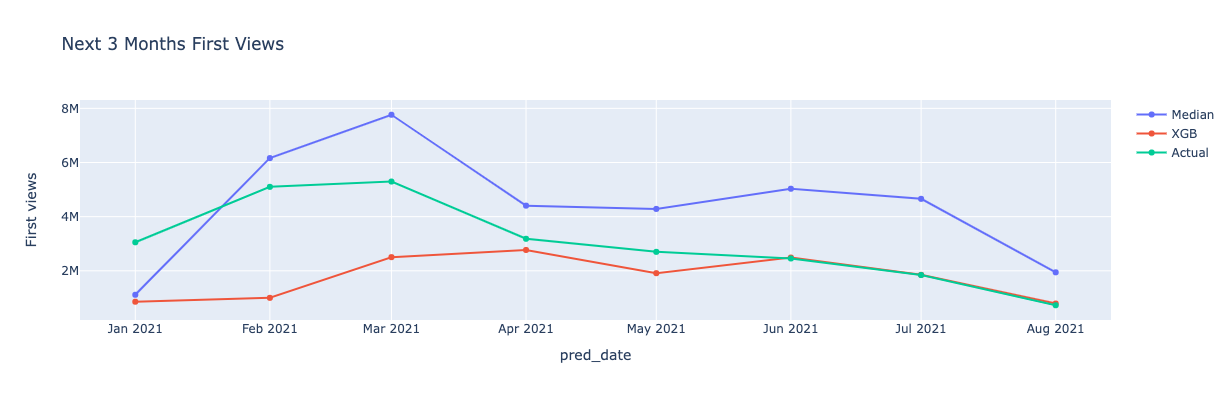

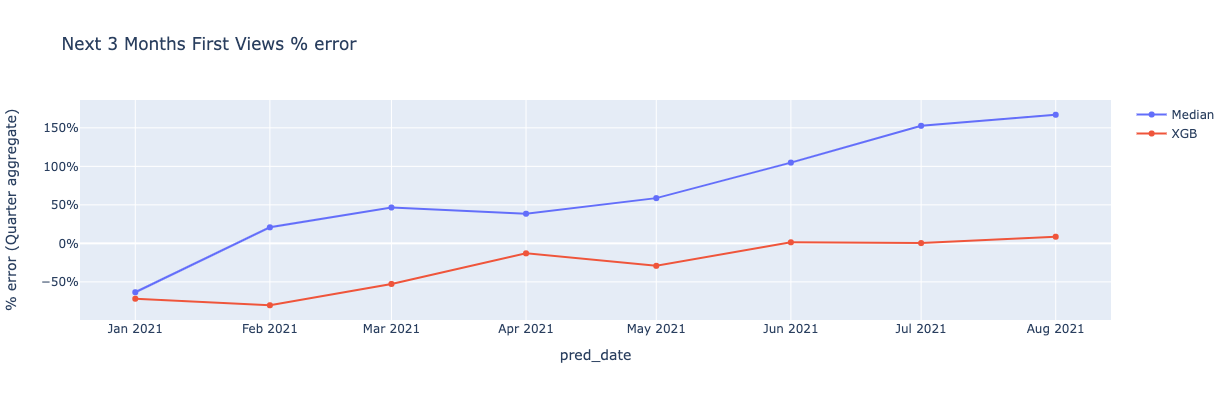

pct_error_first_views_decay_median_mx    81.559488
pct_error_first_views_decay_dev_b        32.178748
dtype: float64

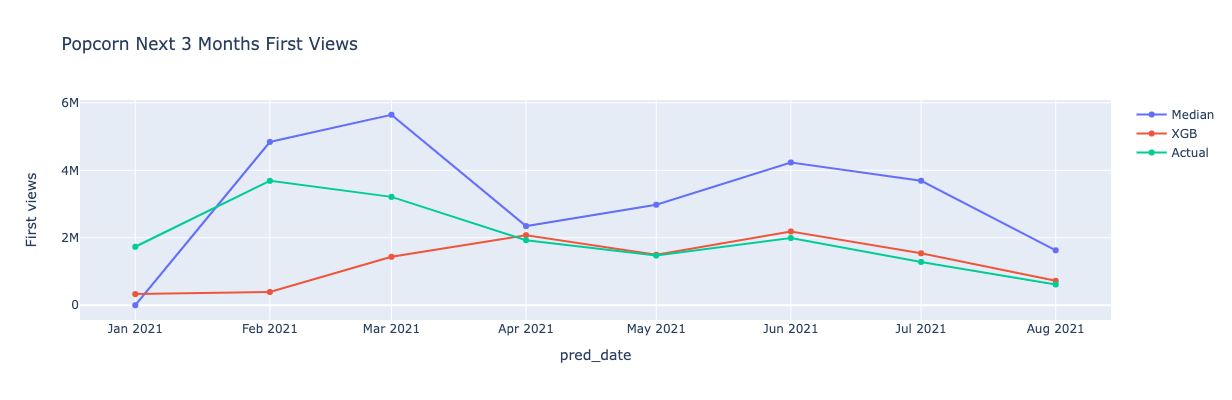

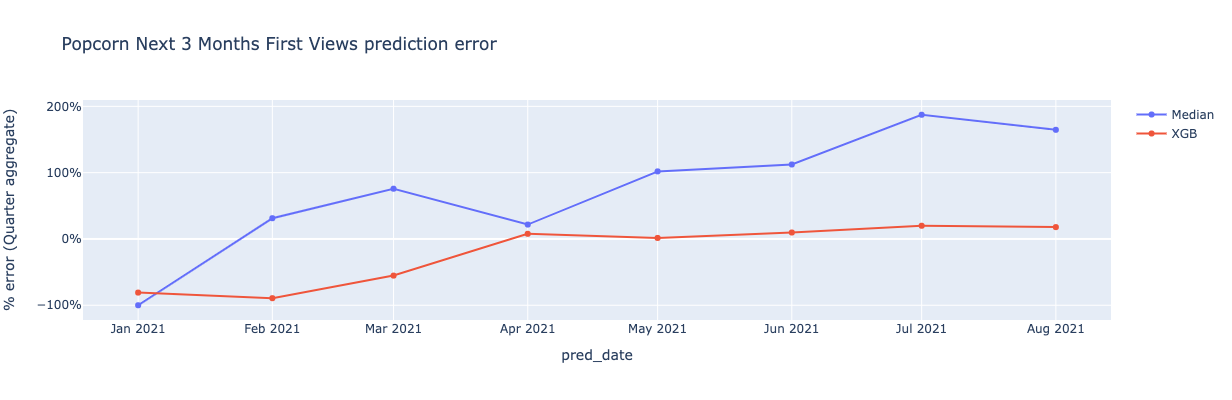

pct_error_first_views_decay_median_mx    99.363343
pct_error_first_views_decay_dev_b        35.283126
dtype: float64

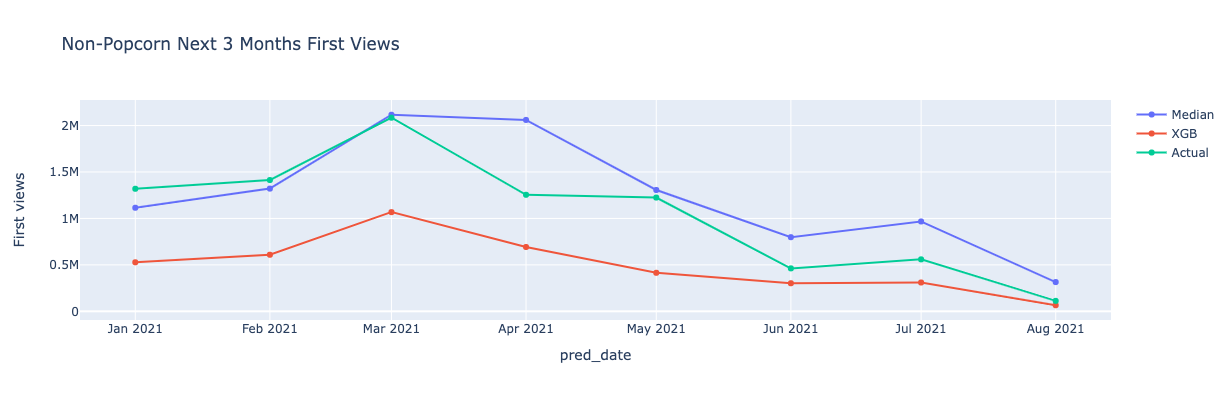

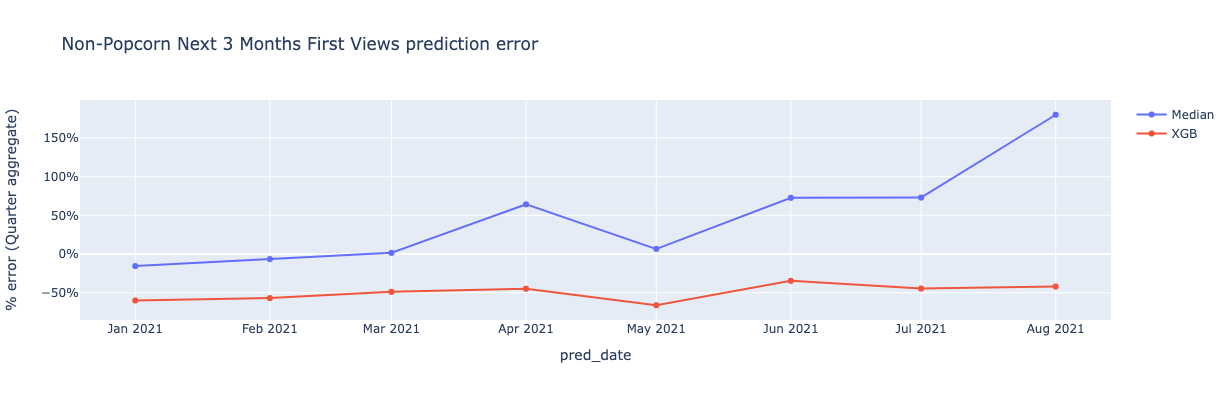

pct_error_first_views_decay_median_mx    52.487846
pct_error_first_views_decay_dev_b        49.714658
dtype: float64

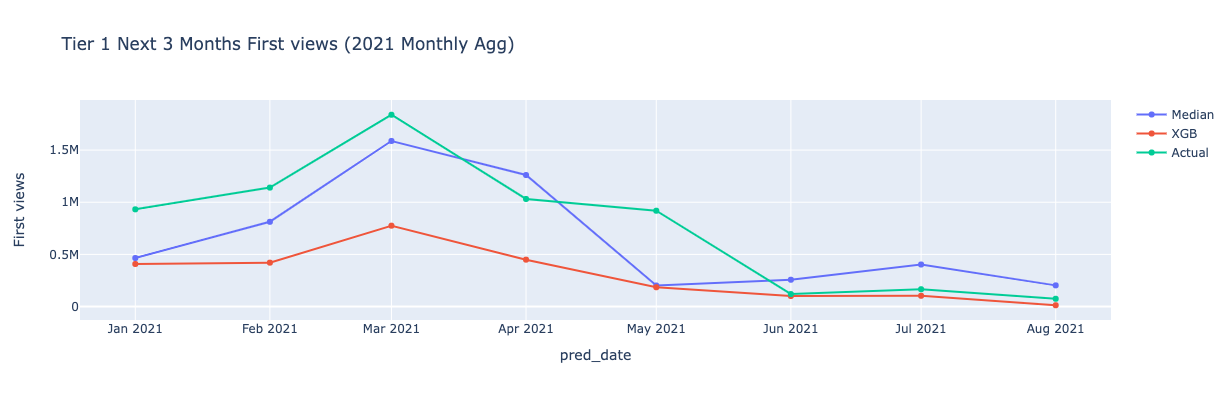

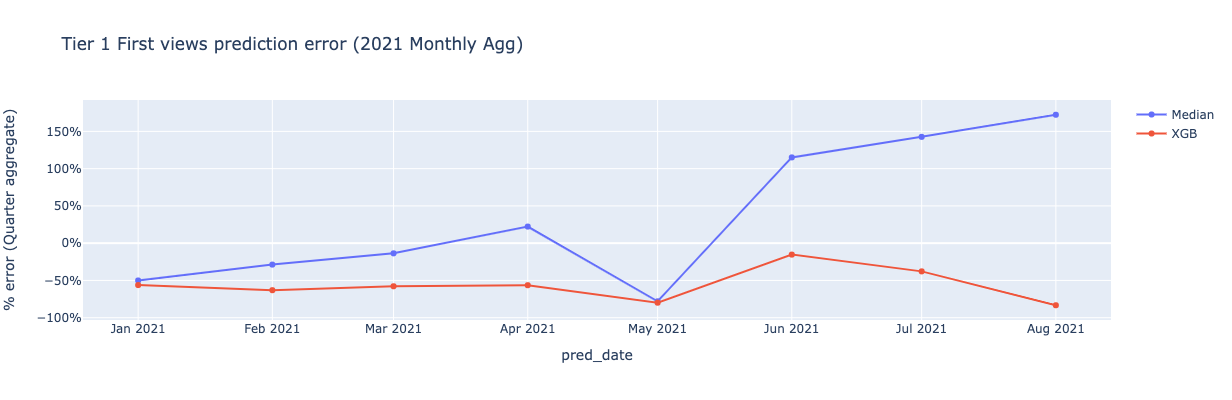

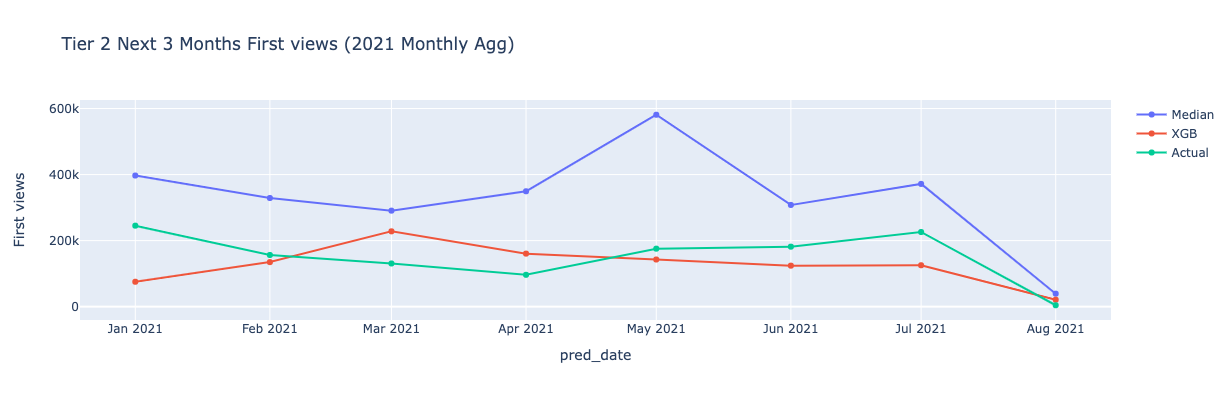

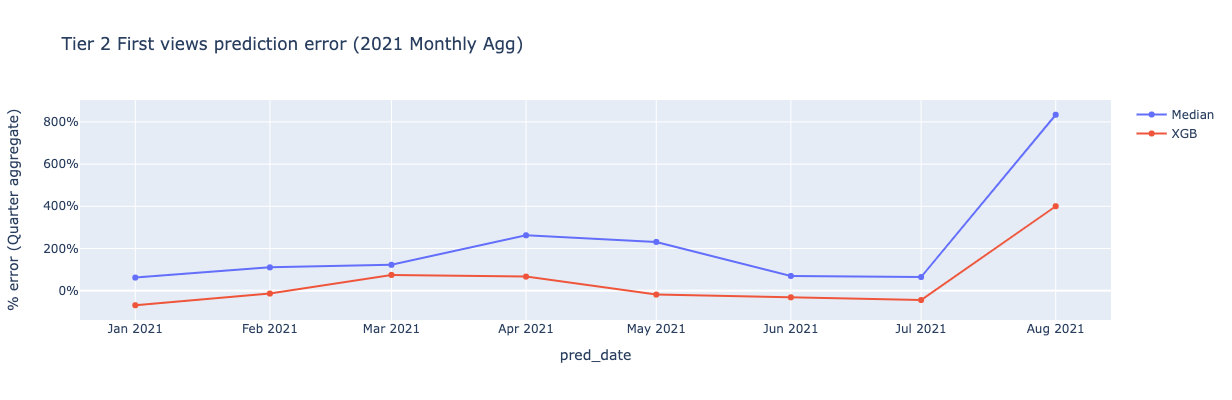

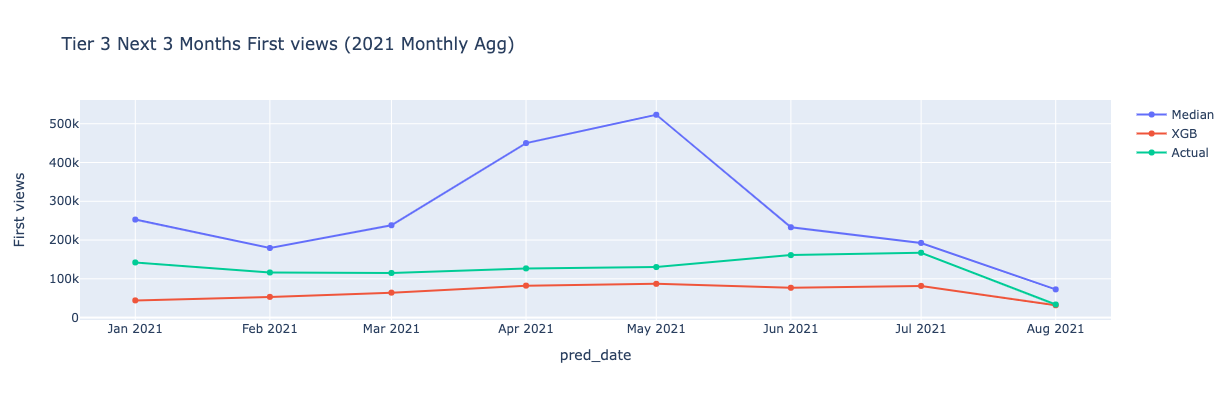

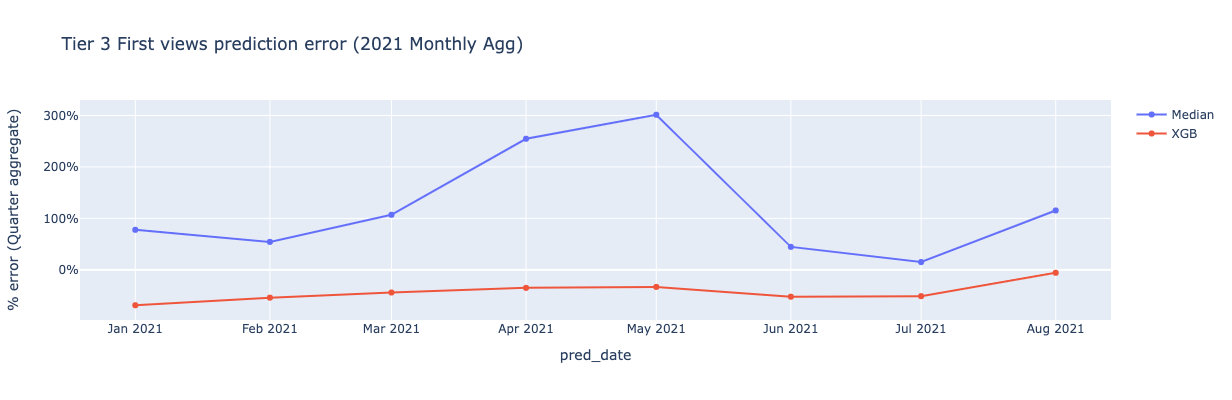

In [29]:
offset = 2
df_eval['first_views'] = df_eval['first_views_actual']
df_eval['first_views_decay_median_mx'] = df_eval['predicted_first_views']
### Plot error 
## Month 
list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
display(df_grp)
# df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
get_pred_plot(df_grp, agg_var,'Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Next 3 Months First Views % error')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

## Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Popcorn Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Popcorn Next 3 Months First Views prediction error ')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

## Non-Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Non-Popcorn Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Non-Popcorn Next 3 Months First Views prediction error ')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

# ## Tiers 
grpby=[agg_var,'tier', 'title_name', 'season_number'] 
df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])

get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 Next 3 Months First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')

get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 Next 3 Months First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')

get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 Next 3 Months First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')



,pred_date,mae_first_views_decay_median_mx,mae_first_views_decay_dev_b,first_views,first_views_decay_median_mx,first_views_decay_dev_b,pct_error_first_views_decay_median_mx,pct_error_first_views_decay_dev_b
0,2021-01-01,25707.666667,19950.615596,434066,289300.0,171613.516330,-33.351149,-60.463728
1,2021-02-01,35627.785714,24601.001090,533352,126219.0,194306.142643,-76.334766,-63.568873
2,2021-03-01,59181.266667,54920.824025,1136570,776107.0,354804.039456,-31.714985,-68.782914
3,2021-04-01,42566.266667,31589.042484,857433,995925.0,422863.424398,16.151933,-50.682628
4,2021-05-01,73824.153846,55409.319066,743691,680657.0,377277.970396,-8.475832,-49.269526
5,2021-06-01,36260.818182,17320.516000,711566,701277.0,891440.273861,-1.445966,25.278649
6,2021-07-01,54446.470588,6087.599442,750523,1641941.0,649939.404082,118.772909,-13.401801
7,2021-08-01,72179.714286,10094.671194,607419,1606553.0,702656.224365,164.488434,15.679000


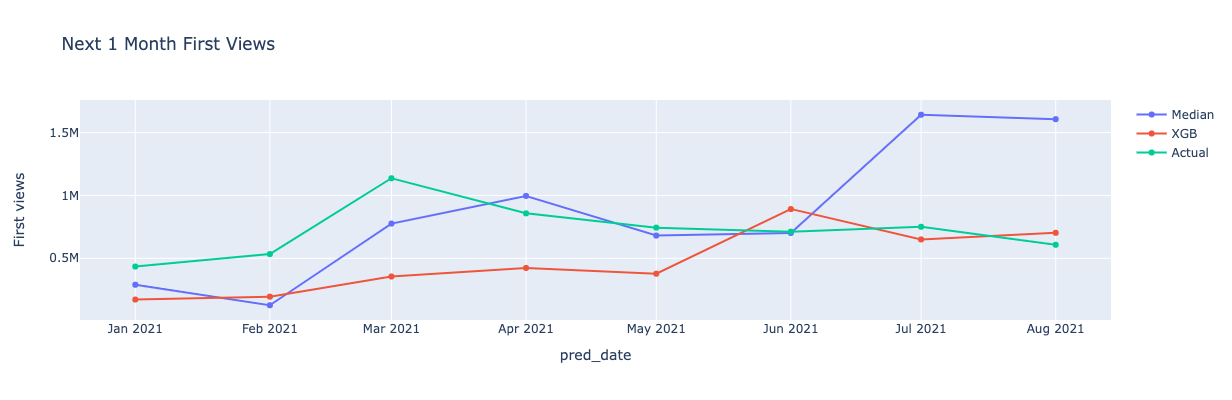

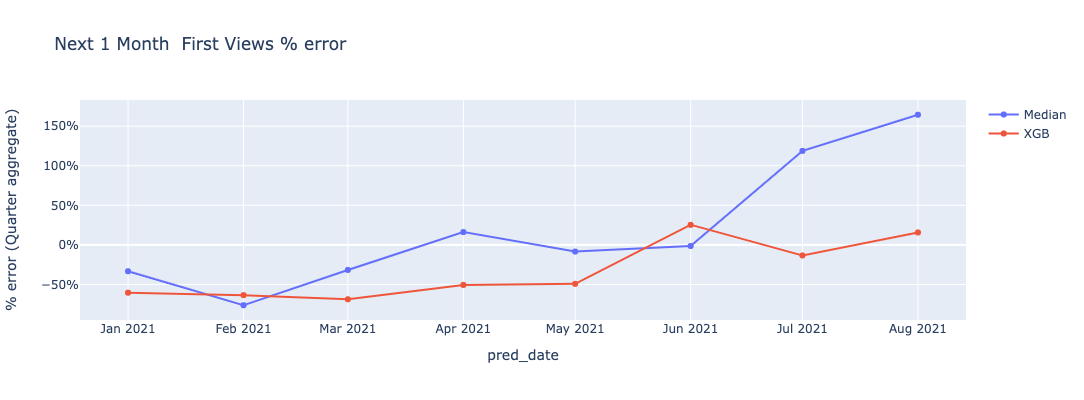

pct_error_first_views_decay_median_mx    56.341997
pct_error_first_views_decay_dev_b        43.390890
dtype: float64

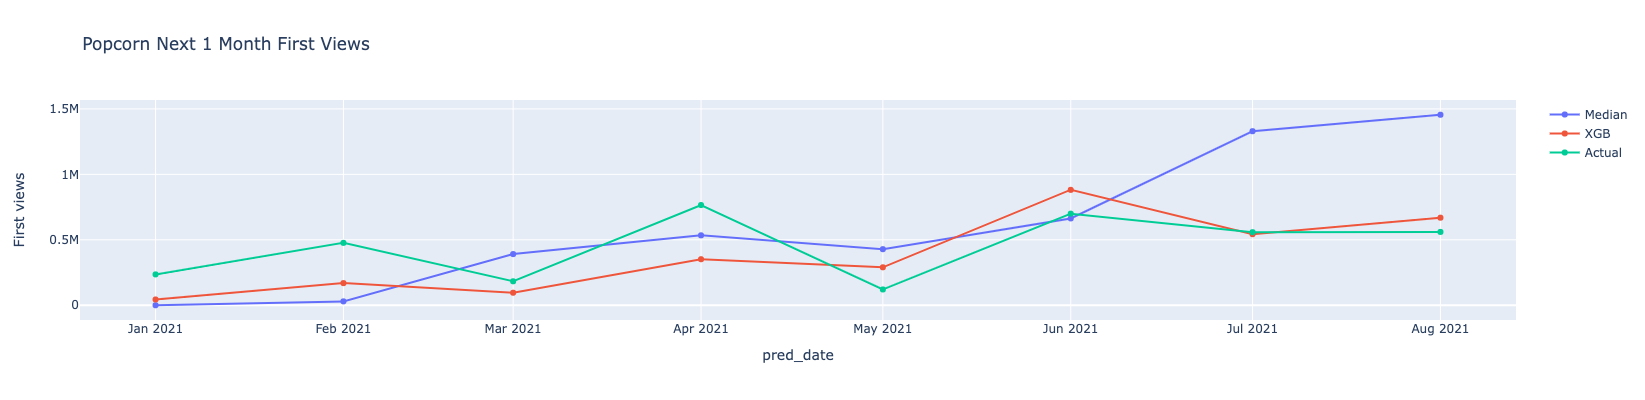

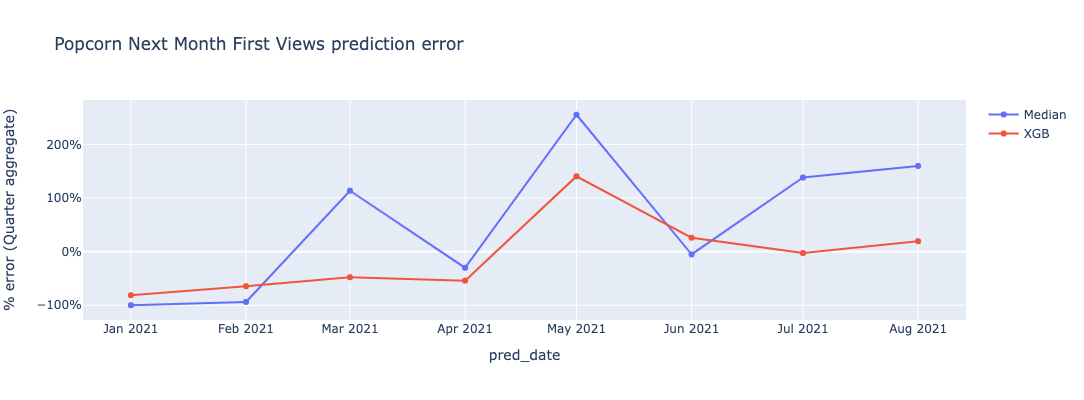

pct_error_first_views_decay_median_mx    112.027704
pct_error_first_views_decay_dev_b         54.521121
dtype: float64

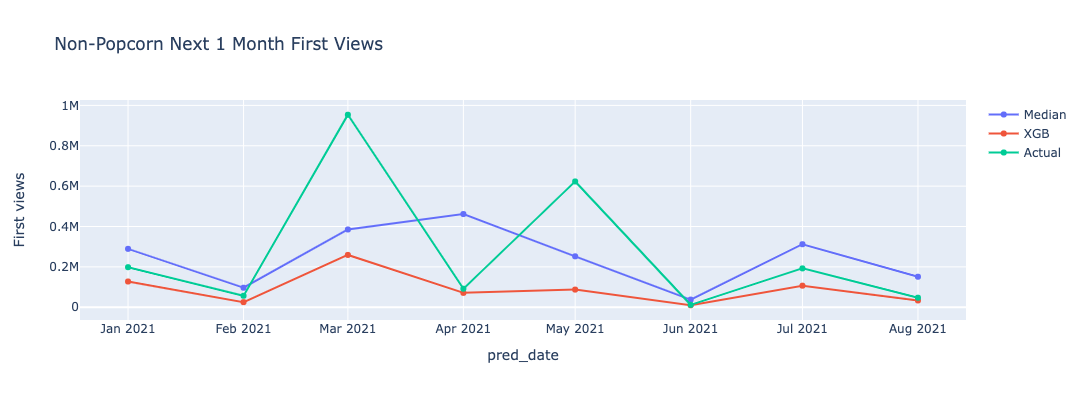

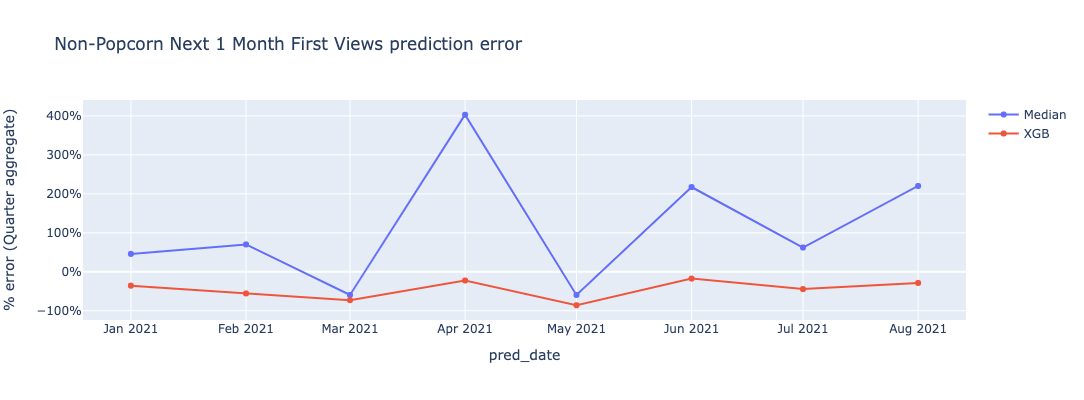

pct_error_first_views_decay_median_mx    142.223730
pct_error_first_views_decay_dev_b         45.415877
dtype: float64

In [22]:
###### offset = 0
df_eval['first_views'] = df_eval['first_views_actual']
df_eval['first_views_decay_median_mx'] = df_eval['predicted_first_views']
### Plot error 
## Month 
list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
# df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
display(df_grp)
get_pred_plot(df_grp, agg_var,'Next 1 Month First Views')
get_pct_error_plot(df_grp, agg_var, 'Next 1 Month  First Views % error')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())


## Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Popcorn Next 1 Month First Views')
get_pct_error_plot(df_grp, agg_var, 'Popcorn Next Month First Views prediction error ')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

## Non-Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Non-Popcorn Next 1 Month First Views')
get_pct_error_plot(df_grp, agg_var, 'Non-Popcorn Next 1 Month First Views prediction error ')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())


In [245]:
df_eval[df_eval.pred_date=='2021-06-01'].sort_values(by='first_views_decay_dev_b', ascending=False)

,title_name,season_number,category,pred_date,first_views_decay_dev_b,first_views_actual,predicted_first_views,title_name_match,title_name_fp,first_views,first_views_decay_median_mx
202,Space Jam: A New Legacy,0,Popcorn,2021-06-01,1.697876e+06,668908,471516.0,Space Jam: A New Legacy,Space Jam: A New Legacy,668908,471516.0
269,The Suicide Squad,0,Popcorn,2021-06-01,1.609387e+06,521458,441019.0,The Suicide Squad,The Suicide Squad,521458,441019.0
220,The Conjuring: The Devil Made Me Do It,0,Popcorn,2021-06-01,1.500525e+06,571118,52621.0,The Conjuring: The Devil Made Me Do It,The Conjuring: The Devil Made Me Do It,571118,52621.0
107,In the Heights,0,Popcorn,2021-06-01,3.837805e+05,193343,52621.0,In the Heights,In The Heights,193343,52621.0
191,Reminiscence,0,Popcorn,2021-06-01,2.856466e+05,38769,38233.0,Reminiscence,Reminiscence,38769,38233.0
83,Gossip Girl,1,Scripted Drama Series,2021-06-01,1.129235e+05,97377,77143.0,Gossip Girl,Gossip Girl,97377,77143.0
160,No Sudden Move,0,Scripted Features,2021-06-01,3.251979e+04,47739,49167.0,No Sudden Move,No Sudden Move,47739,49167.0
273,The White Lotus,1,Scripted Drama Series,2021-06-01,2.612263e+04,101823,138619.0,The White Lotus,The White Lotus,101823,138619.0
261,The Prince,1,Scripted Comedy Series,2021-06-01,2.064242e+04,21193,3250.0,The Prince,The Prince,21193,3250.0
162,Obama: In Pursuit of a More Perfect Union,1,Docu-Series,2021-06-01,2.064137e+04,3807,22671.0,Obama: In Pursuit of a More Perfect Union,Obama: In Pursuit Of A More Perfect Union,3807,22671.0


## Total prediction evaluation

In [30]:
def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i, j in zip(['decay_median_mx'] + list_postfix, ['Median', 'XGB']):
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=j,
                    text= df_plt['effective_start_date'].astype(str) + " " + df_plt['title_name'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=550,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return fig

import plotly.io as pio

def get_agg_first_views(df_in, grpby_title, agg_col, request_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[request_date_col] = pd.to_datetime(df_in[request_date_col])
    df_in['first_view_quarter'] = df_in[request_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[request_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()

    return df_in


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')


# Get actuals & baseline 
agg_var = 'first_view_month'

# ## Get actuals 
grpby_title= ['title_name', 'title_id', 'season_number', 'effective_start_date', 'tier','content_category','category']
df_eval_actuals = df_raw[(df_raw.effective_start_date>='2021-01-01') & (df_raw.effective_start_date<'2021-09-01')].copy()
df_eval_actuals = get_agg_first_views(df_eval_actuals, grpby_title, agg_var,'request_date', 'first_views', 'actual')

## Get Median model baseline. pred = 1 month  
df_median_mx_raw = []
for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['premiere_month'] = df_temp['premiere_date'].dt.to_period('M').dt.to_timestamp()
    df_temp = df_temp[df_temp.premiere_date.dt.strftime('%Y-%m')== datetime.strptime(date_start, '%Y-%m-%d').strftime('%Y-%m')]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)

grpby_title= ['title_name', 'season_number']
# df_title = df_median_mx_raw[grpby_title].drop_duplicates(subset=grpby_title)
# df_title['title_name_match'] = df_title['title_name'].apply(lambda x: process.extractOne(x, df_eval_actuals['title_name'].to_list(), score_cutoff=90))
# name_from_df2_list = df_title['title_name_match'].to_list()
# name_from_df2_list = [_[0] if _ != None else None for _ in name_from_df2_list]
# df_title['title_name_match'] = name_from_df2_list
# df_title.loc[df_title.title_name=='Euphoria Special Episode Part Two', 'title_name_match'] = 'Euphoria Special Episode Part 2: Jules'
# df_title.loc[df_title.title_name.str.contains('Juan Luis'), 'title_name_match'] = 'Juan Luis Guerra 4.40: Entre Mar y Palmeras'

df_median_mx = get_agg_first_views(df_median_mx_raw, grpby_title, agg_var, 'seq_date', 'predicted_first_views', 'median_mx')
df_median_mx['first_views_decay_median_mx'] = df_median_mx['predicted_first_views'] 
df_median_mx = df_median_mx.merge(df_title[['title_name','title_name_match']], how='left', on=['title_name'])
df_median_mx['title_name_fp'] = df_median_mx['title_name']
df_median_mx['title_name'] = df_median_mx['title_name_match']

# Fill in seasons 
df_title_season = df_eval_actuals.drop_duplicates(subset=['title_name','season_number'])
df_median_mx_season = df_median_mx[df_median_mx.season_number!=0]
df_median_mx_noseason = df_median_mx[df_median_mx.season_number==0]
df_median_mx_noseason = df_median_mx_noseason.merge(df_title_season[['title_name','season_number']], on=['title_name'])
df_median_mx_noseason['season_number'] = df_median_mx_noseason['season_number_y'] 
df_median_mx = pd.concat([df_median_mx_season,df_median_mx_noseason[df_median_mx_season.columns]])
df_median_mx = df_median_mx.drop_duplicates(subset=['title_name','season_number', agg_var])


# ## Get aggregated xgb prediction 
df_pred_decay_next = df_pred_decay[df_pred_decay.start_month == df_pred_decay.pred_date]    
df_pred_dev_b = get_agg_first_views(df_pred_decay_next, grpby_title, var_agg,'request_date', f'first_views_decay_{postfix}', postfix)

## Merge actual, median baseline and prediction 
display(df_eval_actuals.head(2))
display(df_median_mx.head(2))
display(df_pred_dev_b.head(2))
df_eval = df_eval_actuals.merge(df_median_mx, on=['title_name', 'season_number', agg_var], how='left')\
        .merge(df_pred_dev_b[['title_name','season_number',agg_var,'first_views_decay_dev_b']], on=['title_name','season_number',agg_var], how='left')
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_decay_median_mx_log'] = np.log(df_eval['first_views_decay_median_mx'])
df_eval['first_views_decay_dev_b_log'] = np.log(df_eval['first_views_decay_dev_b'])
# print(df_eval.title_name.nunique())
# print(df_eval.isnull().sum())
# print(df_eval[df_eval.title_name_match.isnull()].title_name.nunique())
# print(df_eval[df_eval.first_views_decay_dev_b.isnull()].title_name.nunique())
# print(df_eval.columns)
# df_eval = df_eval.dropna()


df_eval_title = df_eval.groupby(by=['title_name','season_number','effective_start_date','tier','category'])\
                        [['first_views','first_views_decay_median_mx','first_views_decay_dev_b']].sum().reset_index()
df_eval_title['first_views_log'] = np.log(df_eval_title['first_views'] )
df_eval_title['first_views_decay_median_mx_log'] = np.log(df_eval_title['first_views_decay_median_mx'])
df_eval_title['first_views_decay_dev_b_log'] = np.log(df_eval_title['first_views_decay_dev_b'])

fig = get_pred_actual_plot(df_eval_title, 'Total', ['decay_dev_b'])
evaluate_pred(df_eval_title, ['decay_median_mx','decay_dev_b'])

AttributeError: 'DataFrame' object has no attribute 'start_month'

In [31]:
df_pred_decay.columns

Index(['program_type', 'season_number', 'first_views', 'ref_ref_tot',
       'category', 'title_name', 'effective_start_date', 'start_year', 'tier',
       'ref_tot', 'content_category', 'first_views_log_dev_b', 'pred_date',
       'first_views_dev_b', 'days_since_premiere', 'first_views_pct_popcorn',
       'first_views_pct', 'first_views_pct_tier', 'request_date',
       'first_views_decay_dev_b'],
      dtype='object')

In [354]:
# df_pred_decay_next = df_pred_decay[df_pred_decay.start_month == df_pred_decay.pred_date]    
df_eval.head()

,title_name,title_id,season_number,effective_start_date,tier,content_category,category,first_view_month,first_views,predicted_first_views,first_views_decay_median_mx,title_name_match,title_name_fp,first_views_decay_dev_b,first_views_log,first_views_decay_median_mx_log,first_views_decay_dev_b_log
0,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-07-01,5917,4220.0,4220.0,100 Foot Wave,100 Foot Wave,NaN,8.685585,8.347590,NaN
1,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-08-01,8994,3160.0,3160.0,100 Foot Wave,100 Foot Wave,NaN,9.104313,8.058327,NaN
2,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-09-01,3248,429.0,429.0,100 Foot Wave,100 Foot Wave,NaN,8.085795,6.061457,NaN
3,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-10-01,768,124.0,124.0,100 Foot Wave,100 Foot Wave,NaN,6.643790,4.820282,NaN
4,30 Coins (30 Monedas),GX4h8rwVrhsPCwwEAAAIl,1,2021-01-05,3,series,International,2021-01-01,8802,589.0,589.0,30 Coins (30 Monedas),30 Coins,NaN,9.082734,6.378426,NaN


## Model diagnosis

In [32]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_ref_tot',
    'ref_ref_tot'
]


df_pred_list = []
for title, date_pred in zip(['Snyder'],['2021-03-01']):
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in.loc[df_train_in.first_views>1000000, 'first_views'] = 1000000
    df_train_in_new = df_train_in[(df_train_in.effective_start_date > datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=120))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(int(round(target_count*0.2)), replace=True)
        df_train_in_tier0_new = df_train_in_new[df_train_in_new.category=='Popcorn'].sample(int(round(target_count*0.5)), replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier0_new, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')]

#     df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
#     df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
#     df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

    ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)
    ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains(title)], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)

NameError: name 'df' is not defined

In [572]:
df[(df.tier==1) & (df.category=='Specials')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,start_year,start_month,start_year_month,start_quarter,first_views,premiering_hours_runtime,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
32,1,special,Specials,Euphoria Special Episode Part 1: Rue,GX7WPJgqYpLZJwwEAAABu,0,original,2020-12-04,2020,12,2020-12,4,112657,0.952,11.632103,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,1,special,Specials,Euphoria Special Episode Part 2: Jules,GX_4Yaww4-L6pXwEAAAAE,0,original,2021-01-23,2021,1,2021-01,1,25780,0.805,10.157354,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,1,special,Specials,Friends: The Reunion,GYJxCDACcN8PDewEAAAAG,0,original,2021-05-27,2021,5,2021-05,2,867809,1.684,13.673727,Friends: The Reunion,tt11337862,"[""Documentary"",""Biography"",""Comedy"",""History"",...",tvSpecial,3.0,0.0,0.0,0.0,251.0,52.0,13.0,303.0
35,1,special,Specials,The Fresh Prince of Bel-Air Reunion,GX7QU5AGnhiLDwwEAAAAj,0,original,2020-11-19,2020,11,2020-11,4,383903,1.234,12.858145,The Fresh Prince of Bel-Air Reunion,tt13315308,"[""Documentary""]",tvSpecial,1.0,0.0,0.0,0.0,94.0,20.0,1.0,114.0


In [567]:
df_test[df_test.title_name.str.contains(title)]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,start_year,start_month,start_year_month,start_quarter,first_views,premiering_hours_runtime,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
34,1,special,Specials,Friends: The Reunion,GYJxCDACcN8PDewEAAAAG,0,original,2021-05-27,2021,5,2021-05,2,867809,1.684,13.673727,Friends: The Reunion,tt11337862,"[""Documentary"",""Biography"",""Comedy"",""History"",...",tvSpecial,3.0,0.0,0.0,0.0,251.0,52.0,13.0,303.0


2021-05-01 146 (4, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


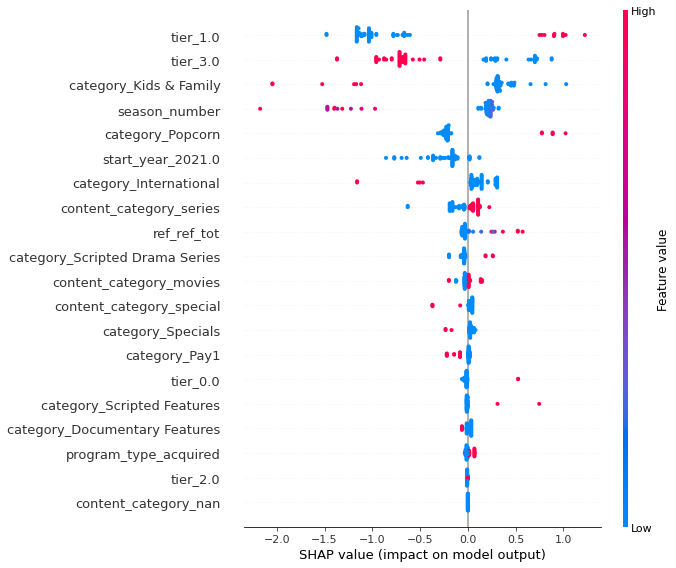

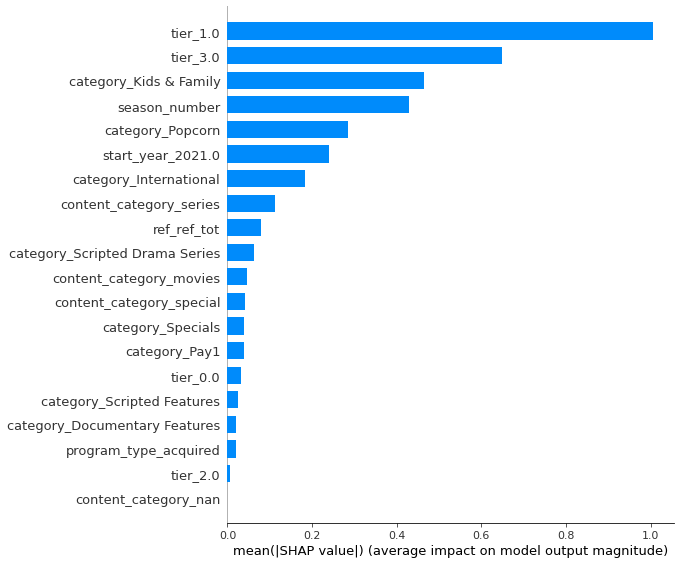

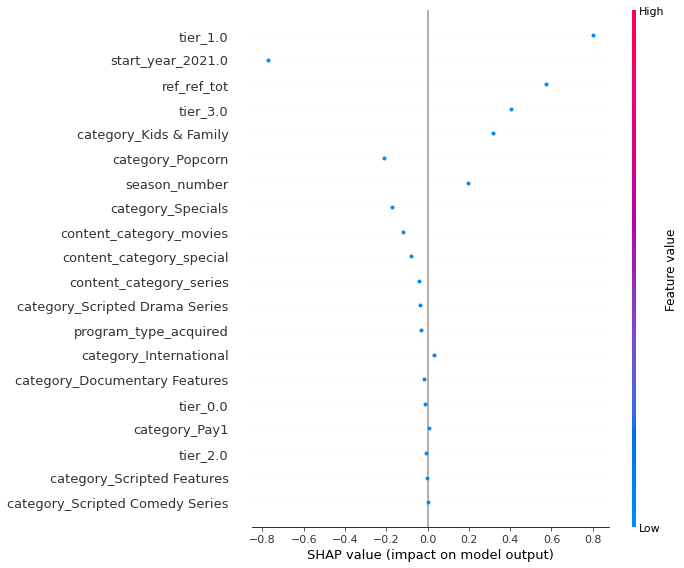

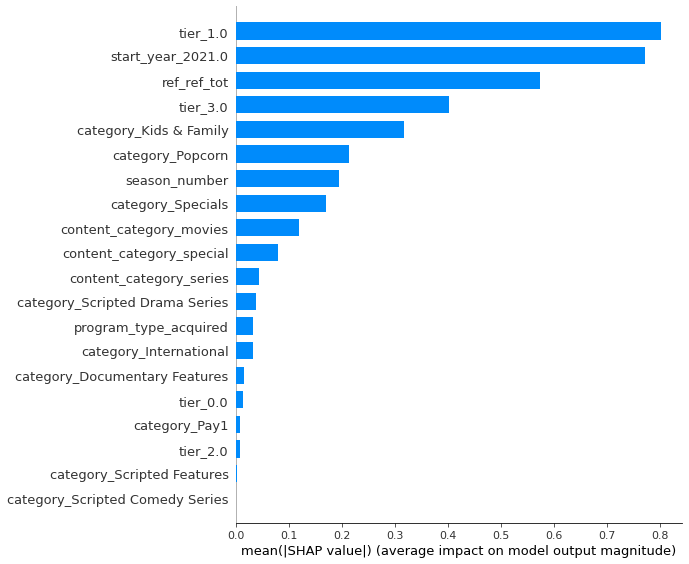

In [566]:

df_pred_list = []
for title, date_pred in zip(['Reunion'],['2021-05-01']):
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in.loc[df_train_in.first_views>1000000, 'first_views'] = 1000000
    df_train_in_new = df_train_in[(df_train_in.effective_start_date > datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=120))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(int(round(target_count*0.2)), replace=True)
        df_train_in_tier0_new = df_train_in_new[df_train_in_new.category=='Popcorn'].sample(int(round(target_count*0.5)), replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier0_new, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')]

#     df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
#     df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
#     df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

    ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)
    ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains(title)], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)